<a href="https://colab.research.google.com/github/karthik-maddukuri/openpose/blob/master/notebooks/OpenPose_final_step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [0]:
import os
from os.path import exists, join, basename, splitext

# os.chdir("drive/My Drive/DL course project")

In [4]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

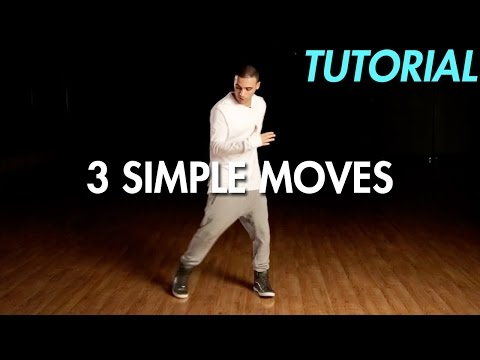

In [5]:
YOUTUBE_ID = 'ujREEgxEP7g'
YouTubeVideo(YOUTUBE_ID)

In [6]:
#If video is from youtube
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:01:48 -to 00:01:53 video.mp4

[youtube] ujREEgxEP7g: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 35.03MiB in 00:00
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-lib

# Detect the Pose on target video



In [7]:
#Detecting pose on our training data
!rm openpose.avi
#For non youtube
# !cd openpose && ./build/examples/openpose/openpose.bin --video "../drive/My Drive/DL course project/vishwesh_input_new.mp4" --disable_blending true --write_json ./output/ --display 0  --write_video ../openpose.avi 
#For youtube video
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --disable_blending true --write_json ./output/ --display 0  --write_video ../openpose.avi 
# convert the result into MP4

!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove 'openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 18.847214 seconds.
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --en

# Visualization of result

In [8]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

In [33]:
%pwd

'/content'

In [32]:
#PLEASE DO ONLY IF REQUIRED
#for converting the video to images

!ffmpeg -i ./output.mp4 ./drive/My\ Drive/CV\ 2/Everybody-dance-now-master/dataset/train_A/pose%06d.jpg -hide_banner


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from './output.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
  Duration: 00:00:04.96, start: 0.000000, bitrate: 507 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuvj420p(pc), 1920x1080 [SAR 1:1 DAR 16:9], 503 kb/s, 24 fps, 24 tbr, 12288 tbn, 48 tbc (default)
    Metadata:
      handler_name    : VideoHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mjpeg (native))
Press [q] to stop, [?] for help
Output #0, image2, to './drive/My Drive/CV 2/Everybody-dance-now-master/dataset/train_A/pose%06d.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 1920x1080 [SAR 1:1 DAR 16:9], q=2-31, 200 kb/s, 24 fps, 24 tbn, 24 tbc (default)
    Metadata:
      handler_name    : VideoHandler
  

In [36]:
# moving the original images to train_B
!ffmpeg -i ./video.mp4 ./drive/My\ Drive/CV\ 2/Everybody-dance-now-master/dataset/train_B/img%06d.jpg -hide_banner

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from './video.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
  Duration: 00:00:04.96, start: 0.041000, bitrate: 1237 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p, 1920x1080 [SAR 1:1 DAR 16:9], 1234 kb/s, 23.98 fps, 23.98 tbr, 24k tbn, 47.95 tbc (default)
    Metadata:
      handler_name    : VideoHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mjpeg (native))
Press [q] to stop, [?] for help
[swscaler @ 0x555ea453e000] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to './drive/My Drive/CV 2/Everybody-dance-now-master/dataset/train_B/img%06d.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf57.83.100
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 1920x1080 [SAR 1:1 DAR 16:9], q=2-31

# Download the result to local repository

In [0]:
from google.colab import files
files.download('./video.mp4')

In [0]:
from google.colab import files
files.download('./output.mp4')